In [ ]:
import sys

sys.path.insert(0, "..")

import torch
from torchvision.io.image import read_image
from src.model.model import UNETNetwork
from torch.utils.data import DataLoader
from src.dataloader.dataset.he_dataset import HeDataset
import matplotlib.pyplot as plt
from src.dataloader.transform import ToNormalized, ImagenetNormalize
from torchvision.transforms.v2 import Compose
from src.loss import dice_index

/home/hackerton-cloud/miniforge3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def accuracy(prediction, labels):
    correct = prediction.argmax(dim=1) == torch.argmax(labels, dim=1)
    return correct.sum() / prediction[:, 0, ...].flatten().size(0)


def accuracy_per_channel(prediction, labels):
    correct_per_class = ((labels == 1) == (prediction > 0.5)).sum(dim=[0, 2, 3])
    return correct_per_class / prediction[:, 0, ...].flatten().size(0)


def dice_index_per_channel(
    pred: torch.Tensor,
    target: torch.Tensor,
    epsilon=1e-4,
):
    pred_flat = pred.permute([1, 0, 2, 3]).flatten(1)
    label_flat = target.permute([1, 0, 2, 3]).flatten(1)
    nominator = 2 * torch.sum(pred_flat * label_flat, dim=1)
    denominator = torch.sum(pred_flat, dim=1) + torch.sum(label_flat, dim=1)
    return (nominator + epsilon) / (denominator + epsilon)

In [ ]:
model = UNETNetwork(numberClass=3)
model.load_state_dict(
    torch.load(
        "/mnt/storage/projects/semi-he/data/model/20241210_233424_tiger_baseline_fix_lambda_0.02max_100_bs16/445_tiger_baseline_fix_lambda_0.02max_100_bs16_model.pt",
    )
)
model.cuda()

preprocessor = Compose([ToNormalized(), ImagenetNormalize()])
model.eval()

BATCH_SIZE = 128
dataset = HeDataset("/mnt/storage/Dataset130_ukmtils/", "../data/he_dataset/")
# dataset = HeDataset("/mnt/storage/Dataset110_Tiger/", "../data/he_dataset_tiger/")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
iou_array = torch.zeros([len(dataset) // BATCH_SIZE + 1, 3])
accuracy_array = torch.zeros([len(dataset) // BATCH_SIZE + 1, 3])

for i, (image, mask) in enumerate(dataloader):
    image_after, mask = preprocessor(image.cuda(), mask.cuda())
    with torch.no_grad():
        prediction = model(image_after)
    iou_array[i] = dice_index_per_channel(prediction.sigmoid(), mask)
    accuracy_array[i] = accuracy_per_channel(prediction.sigmoid(), mask)

# plt.figure()
# plt.title("IOU Hist")
# plt.hist(iou_array)
# plt.figure()
# plt.title("Accuracy Hist")
# plt.hist(accuracy_array)

In [ ]:
model = UNETNetwork(numberClass=3)
model.load_state_dict(
    torch.load(
        "/mnt/storage/projects/semi-he/data/model/20241211_004039_tiger_proposed_fix_lambda_0.02max_500_bs16/361_tiger_proposed_fix_lambda_0.02max_500_bs16_model.pt"
    )
)
model.cuda()

preprocessor = Compose([ToNormalized(), ImagenetNormalize()])
model.eval()

BATCH_SIZE = 128
dataset = HeDataset("/mnt/storage/Dataset130_ukmtils/", "../data/he_dataset/")
# dataset = HeDataset("/mnt/storage/Dataset110_Tiger/", "../data/he_dataset_tiger/")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
uncertainty_array = torch.zeros([len(dataset) // BATCH_SIZE + 1])
iou_array = torch.zeros([len(dataset) // BATCH_SIZE + 1])
accuracy_array = torch.zeros([len(dataset) // BATCH_SIZE + 1])

filtered_array = []

for i, (image, mask) in enumerate(dataloader):
    image_after, mask = preprocessor(image.cuda(), mask.cuda())
    with torch.no_grad():
        prediction = model(image_after)

    # Dirichlet version
    alpha = prediction.relu() + 1
    dirichlet_strength = alpha.sum(dim=1)
    prediction = alpha / dirichlet_strength.unsqueeze(1)

    uncertainty_median = (
        (3 / dirichlet_strength).flatten(start_dim=1).median(dim=1).values
    )

    selected_prediction = prediction[uncertainty_median < 0.01]
    selected_mask = mask[uncertainty_median < 0.01]

    iou_array[i] = dice_index(selected_prediction, selected_mask)
    uncertainty_array[i] = (3 / dirichlet_strength).mean()
    accuracy_array[i] = accuracy(selected_prediction, selected_mask)

    wanted_samples = (uncertainty_median < 0.01).argwhere() + i
    for index in wanted_samples:
        filtered_array.append(index[0])


plt.figure()
plt.title("IOU Hist")
plt.hist(iou_array)
plt.figure()
plt.title("Uncertainty Hist")
plt.hist(uncertainty_array)
plt.figure()
plt.title("Accuracy Hist")
plt.hist(accuracy_array)

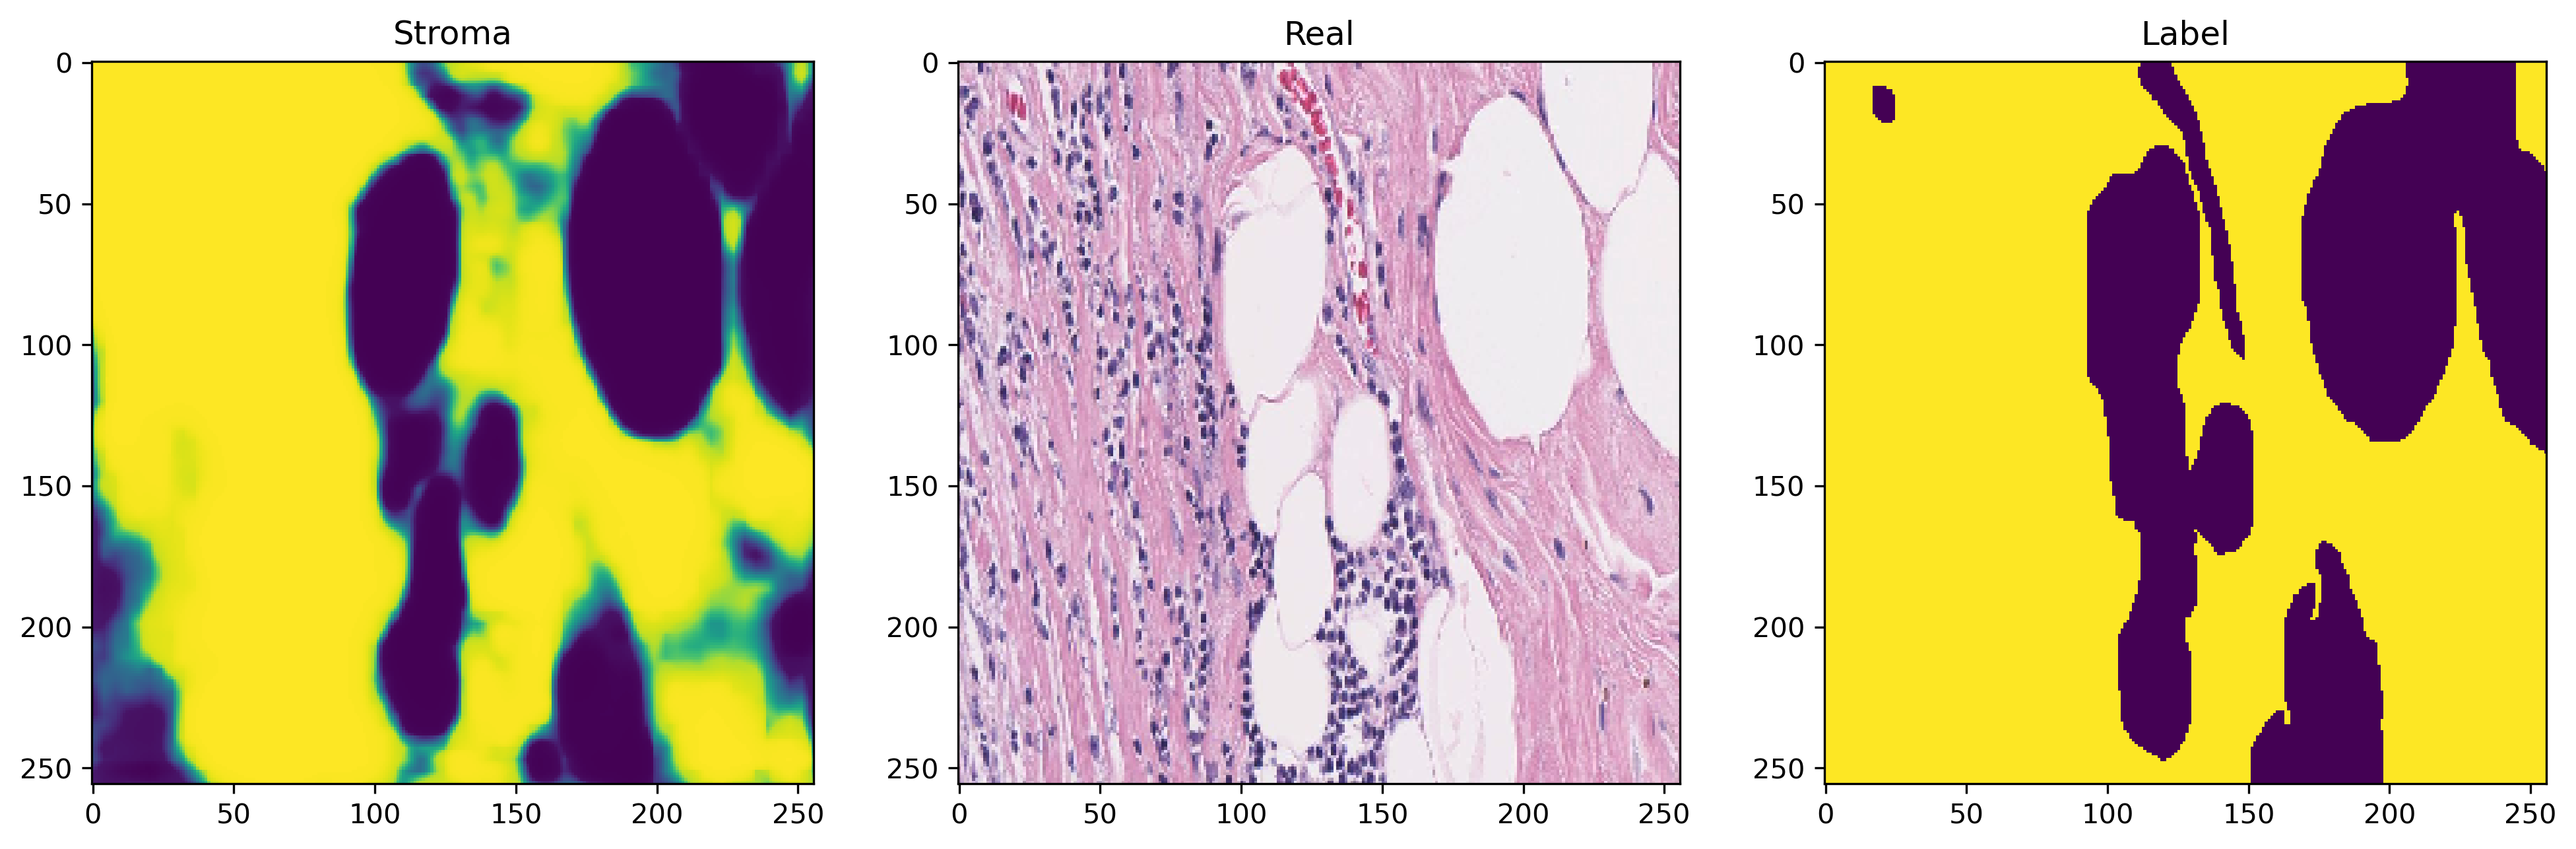

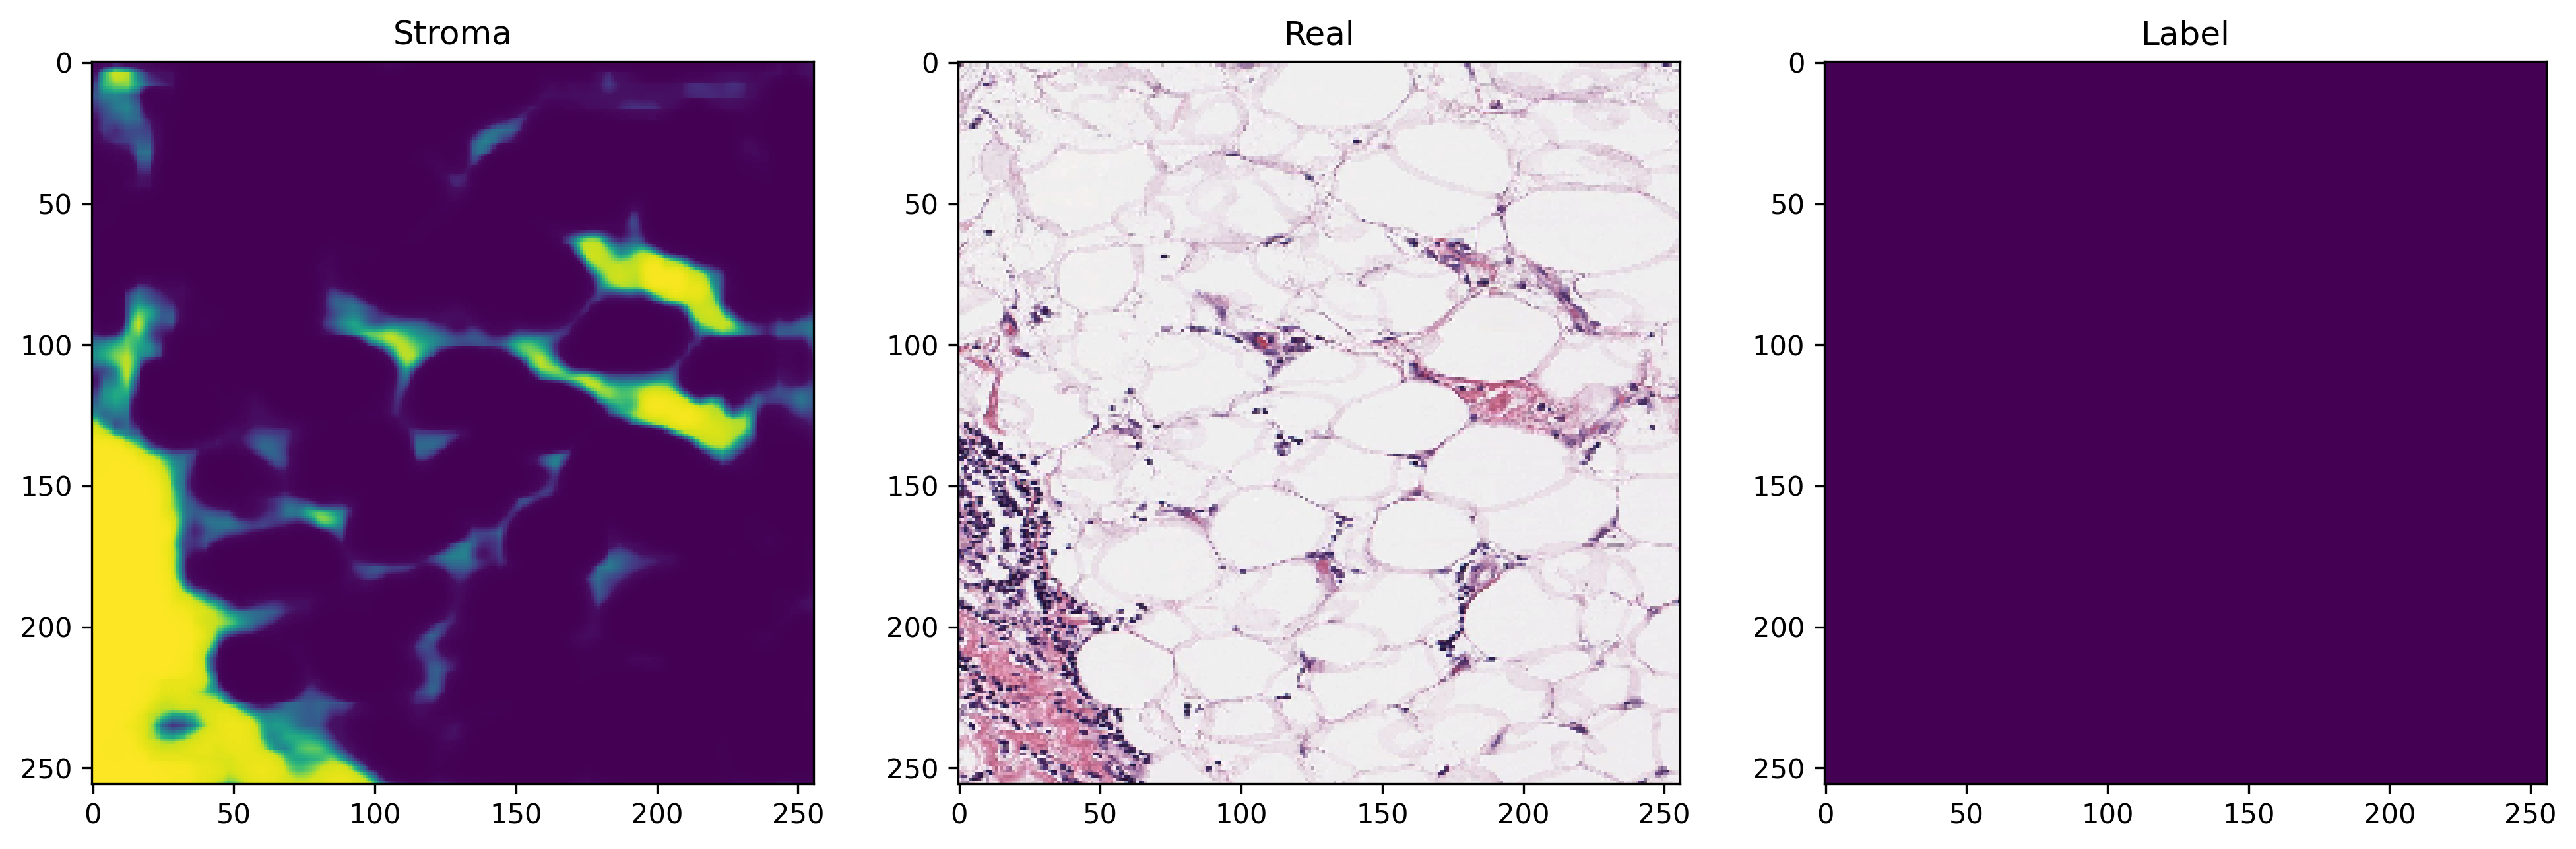

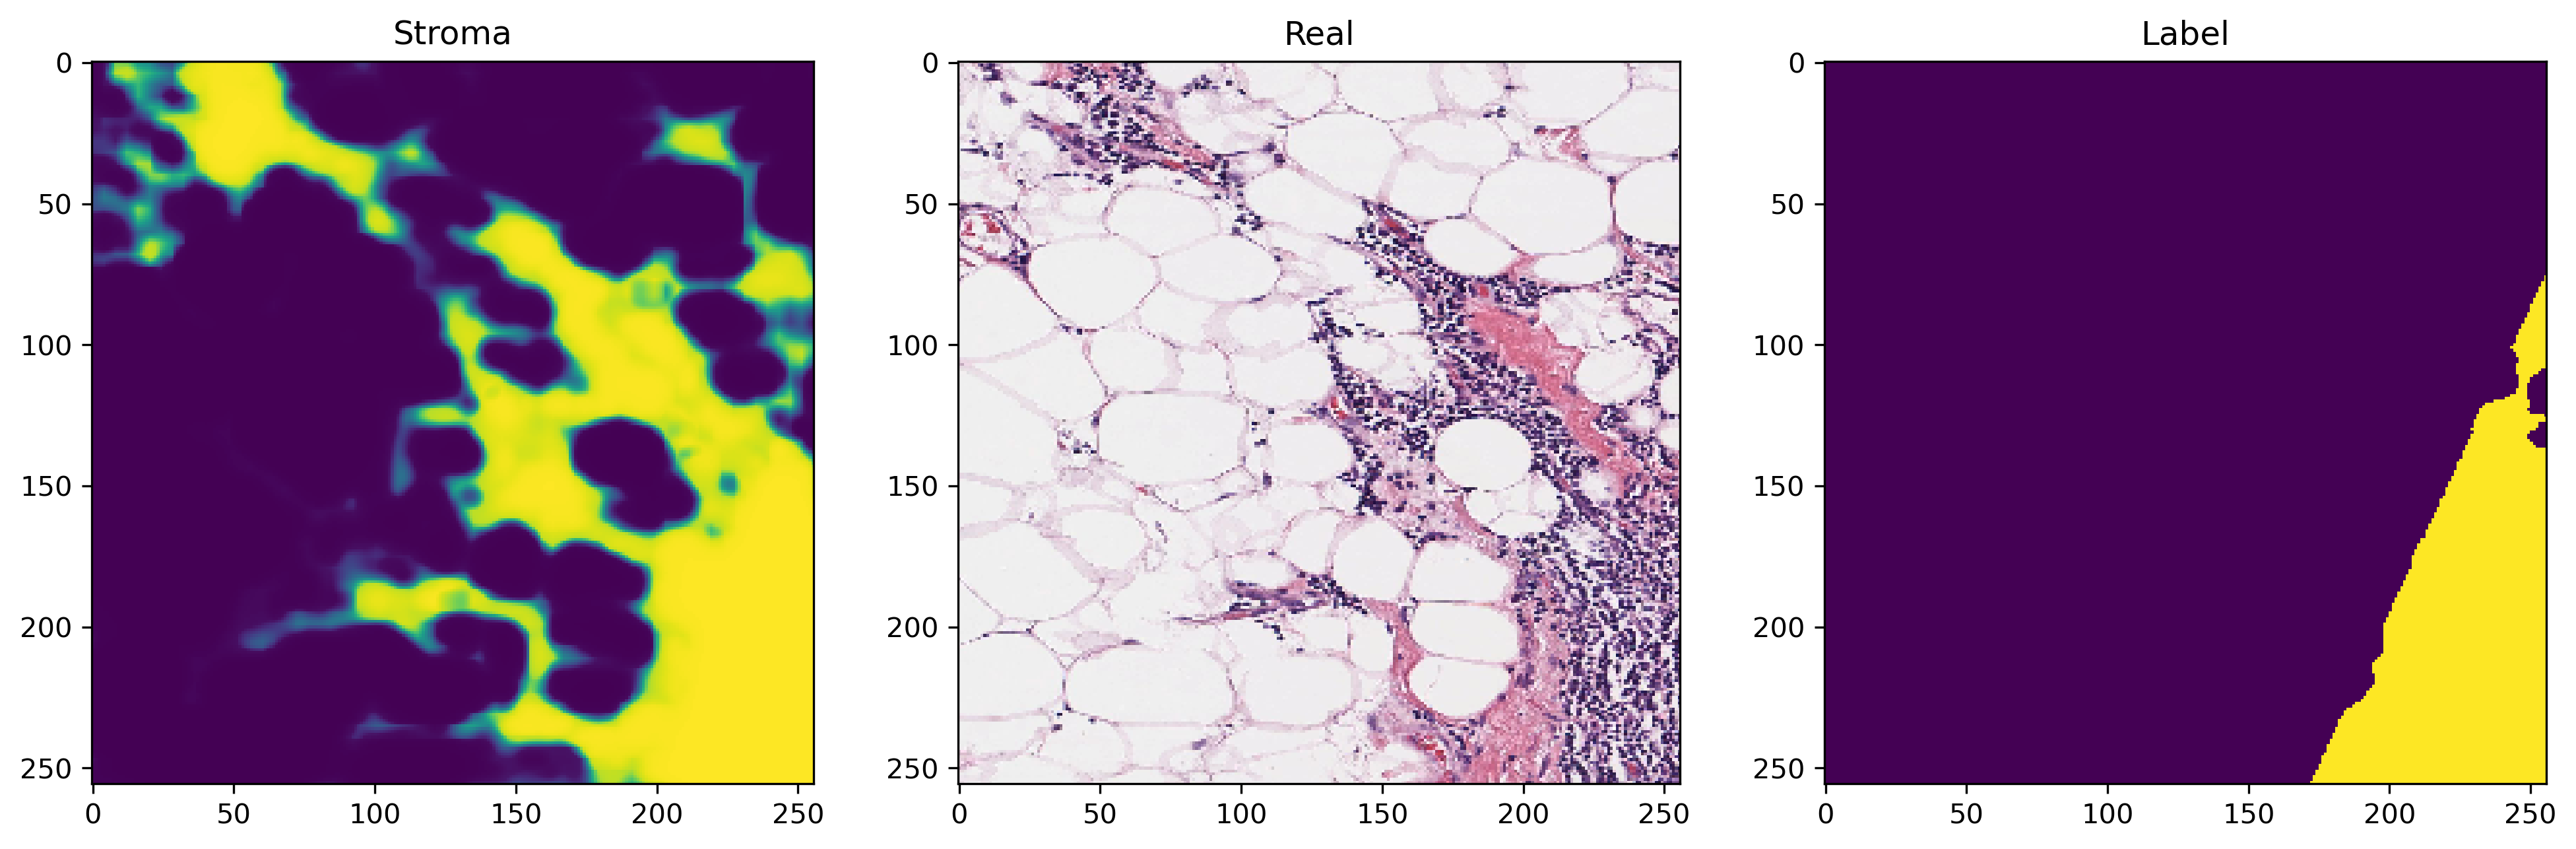

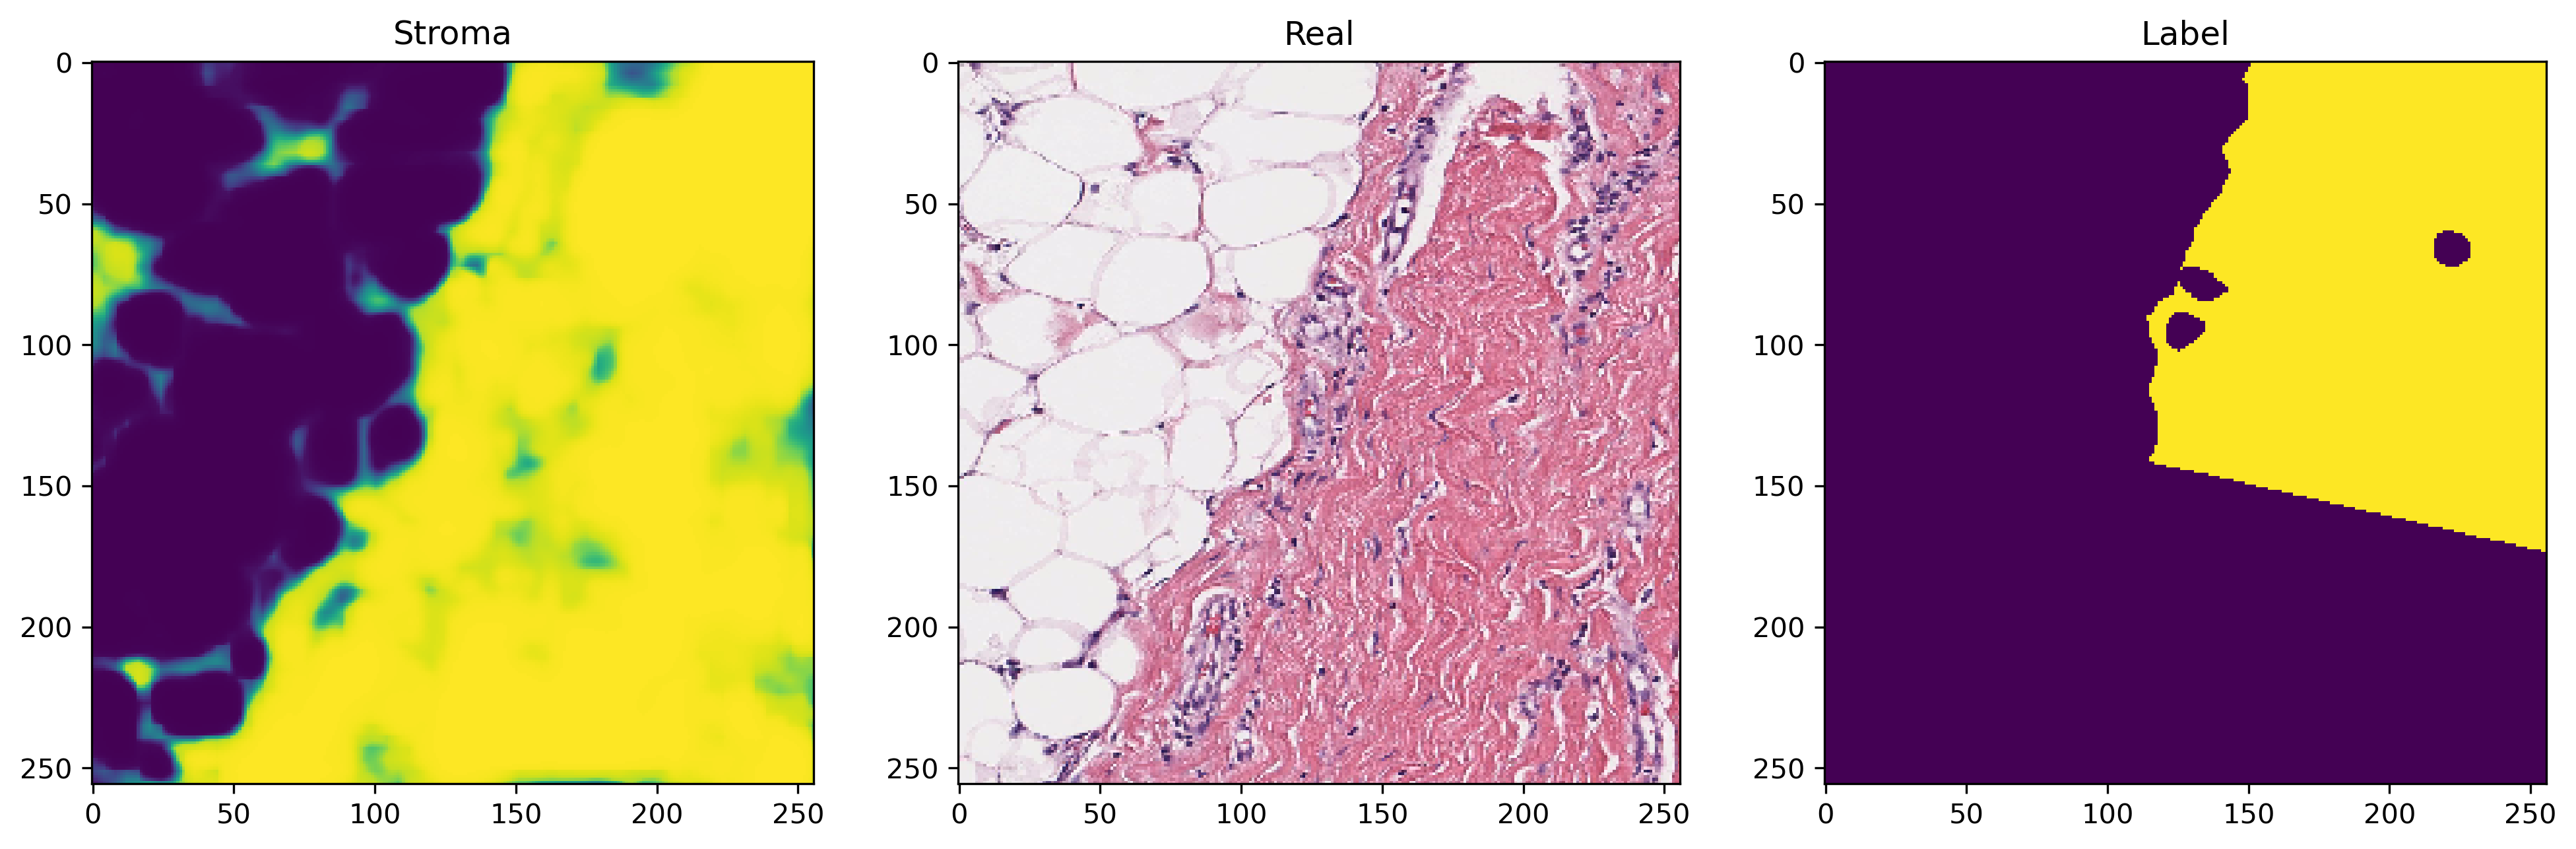

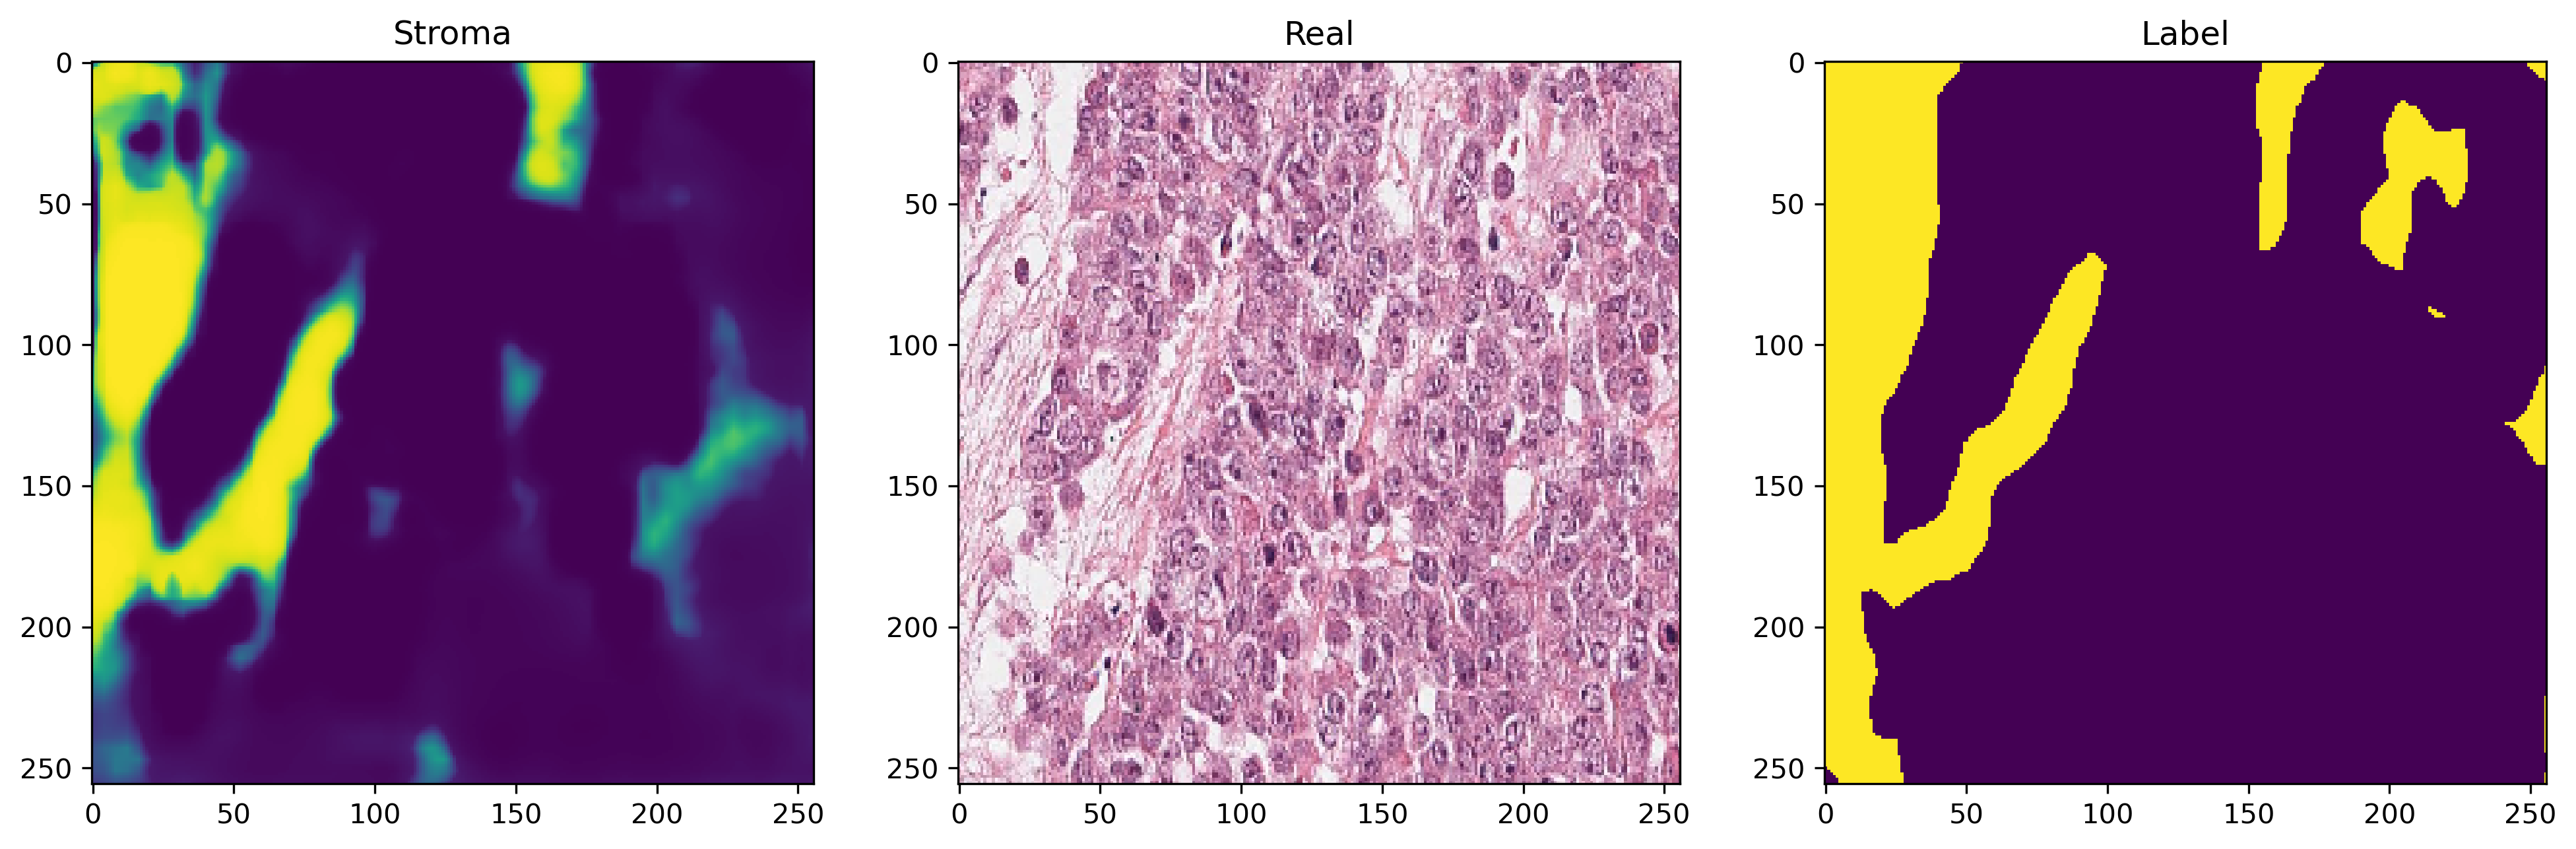

In [4]:
pictures_to_select = torch.where((uncertainty_median > 0.01))[0]
for i in range(5):
    idx = pictures_to_select[i]
    figure, axes = plt.subplots(1, 3, figsize=(16, 9), dpi=300)
    axes[0].set_title("Stroma")
    axes[0].imshow(prediction[idx, 2].cpu())
    # axes[1].set_title("Uncertainty")
    # axes[1].imshow((3 / dirichlet_strength[idx, 0]).cpu())
    axes[1].set_title("Real")
    axes[1].imshow(image[idx].permute(1, 2, 0))
    axes[2].set_title("Label")
    axes[2].imshow(mask[idx, 2].cpu())